# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 6.77KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

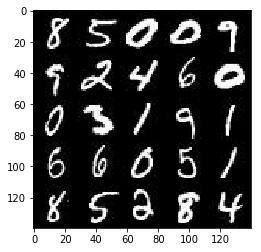

In [126]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

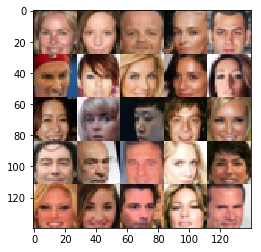

In [127]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [128]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [151]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [152]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # Input Images are 28x28x3
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        # 14x14x56
                
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x112
        
        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x224
        
        layer4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(layer4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 4x4x224
                
        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [153]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        # 7x7x224
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        # 14x14x112 now
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        # 14x14x112 now
        
        x4 = tf.layers.conv2d_transpose(relu3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * x4, x4)
        # 14x14x112 now
                
        # create the logits
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
    
    return out  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [154]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_model_real)))
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)* (1 - smooth)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [155]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    disc_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in trainable_vars if var.name.startswith('generator')]
        
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        
    
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [156]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [159]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    disc_loss, gen_loss = model_loss(input_real, input_z, data_shape[3])
    
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images= batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(gen_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2089... Generator Loss: 0.3382
Epoch 1/2... Discriminator Loss: 0.0769... Generator Loss: 3.8140
Epoch 1/2... Discriminator Loss: 2.5677... Generator Loss: 0.3536
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.5443
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 1.6963
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 1.0646
Epoch 1/2... Discriminator Loss: 2.0478... Generator Loss: 0.4225
Epoch 1/2... Discriminator Loss: 1.6907... Generator Loss: 0.4080
Epoch 1/2... Discriminator Loss: 2.7259... Generator Loss: 0.3615
Epoch 1/2... Discriminator Loss: 3.2160... Generator Loss: 0.3732


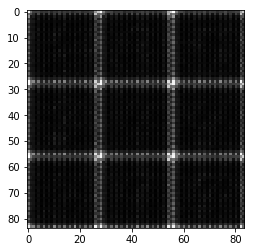

Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 2.1129... Generator Loss: 0.4576
Epoch 1/2... Discriminator Loss: 2.6989... Generator Loss: 0.3640
Epoch 1/2... Discriminator Loss: 1.9973... Generator Loss: 0.4230
Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 1.1408... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.5052
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.6373
Epoch 1/2... Discriminator Loss: 1.4772... Generator Loss: 0.4673
Epoch 1/2... Discriminator Loss: 1.1047... Generator Loss: 0.5516


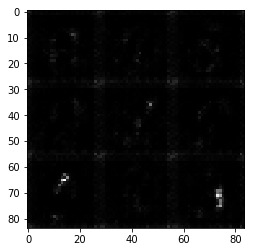

Epoch 1/2... Discriminator Loss: 1.7166... Generator Loss: 0.3720
Epoch 1/2... Discriminator Loss: 1.5526... Generator Loss: 0.4026
Epoch 1/2... Discriminator Loss: 1.5657... Generator Loss: 0.4555
Epoch 1/2... Discriminator Loss: 1.6234... Generator Loss: 1.3889
Epoch 1/2... Discriminator Loss: 1.3063... Generator Loss: 0.5407
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 0.5144
Epoch 1/2... Discriminator Loss: 0.8609... Generator Loss: 1.8345
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 0.9805... Generator Loss: 0.6685
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 0.9457


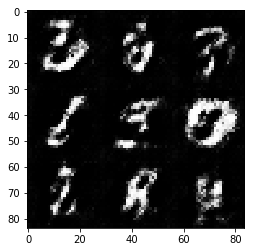

Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 0.5156
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 0.4899
Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 0.7317... Generator Loss: 1.3049
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.5844
Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.2328... Generator Loss: 0.4944
Epoch 1/2... Discriminator Loss: 0.7417... Generator Loss: 0.7455
Epoch 1/2... Discriminator Loss: 1.3032... Generator Loss: 0.5047
Epoch 1/2... Discriminator Loss: 0.6563... Generator Loss: 2.6841


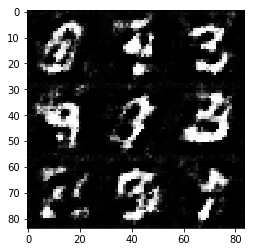

Epoch 1/2... Discriminator Loss: 0.5537... Generator Loss: 1.2606
Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 0.4170
Epoch 1/2... Discriminator Loss: 1.1939... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 1.9351... Generator Loss: 0.3366
Epoch 1/2... Discriminator Loss: 1.8537... Generator Loss: 0.3554
Epoch 1/2... Discriminator Loss: 1.6822... Generator Loss: 0.3666
Epoch 1/2... Discriminator Loss: 1.8825... Generator Loss: 0.3845
Epoch 1/2... Discriminator Loss: 1.9463... Generator Loss: 0.3432
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 0.6432... Generator Loss: 1.6631


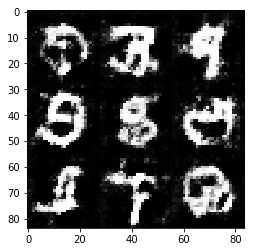

Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 0.5263
Epoch 1/2... Discriminator Loss: 1.8491... Generator Loss: 0.3551
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.3417
Epoch 1/2... Discriminator Loss: 0.4228... Generator Loss: 1.5191
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 0.7272
Epoch 1/2... Discriminator Loss: 0.7114... Generator Loss: 1.3089
Epoch 1/2... Discriminator Loss: 1.5976... Generator Loss: 0.4730
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 3.0578
Epoch 1/2... Discriminator Loss: 1.7472... Generator Loss: 0.3666
Epoch 1/2... Discriminator Loss: 1.5119... Generator Loss: 0.4085


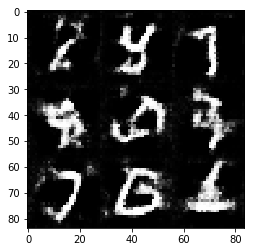

Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 0.7116
Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 1.4096
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 0.5732
Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 0.5262
Epoch 1/2... Discriminator Loss: 0.6971... Generator Loss: 1.6366
Epoch 1/2... Discriminator Loss: 1.0440... Generator Loss: 1.4789
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.5964
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 0.5220


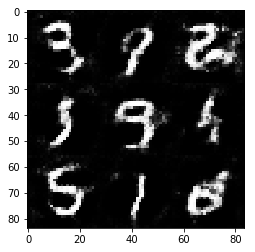

Epoch 1/2... Discriminator Loss: 1.6371... Generator Loss: 0.3712
Epoch 1/2... Discriminator Loss: 0.9379... Generator Loss: 1.3424
Epoch 1/2... Discriminator Loss: 0.6856... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.7589
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.4959
Epoch 1/2... Discriminator Loss: 1.4830... Generator Loss: 0.4068
Epoch 1/2... Discriminator Loss: 0.5830... Generator Loss: 1.4428
Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 0.8314
Epoch 1/2... Discriminator Loss: 1.5360... Generator Loss: 0.4112
Epoch 1/2... Discriminator Loss: 0.8945... Generator Loss: 1.3140


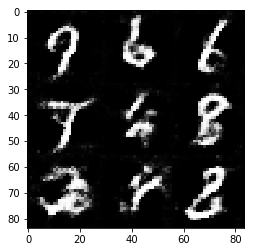

Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 1.6222... Generator Loss: 0.3831
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.4476
Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 0.7238... Generator Loss: 1.0819
Epoch 1/2... Discriminator Loss: 0.5033... Generator Loss: 1.6877
Epoch 1/2... Discriminator Loss: 0.7727... Generator Loss: 1.5398
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.4831


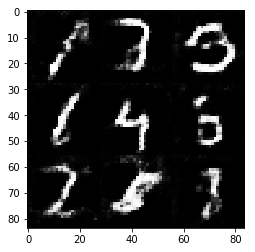

Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 0.3964
Epoch 1/2... Discriminator Loss: 1.5823... Generator Loss: 0.4695
Epoch 1/2... Discriminator Loss: 1.1158... Generator Loss: 0.6569
Epoch 1/2... Discriminator Loss: 0.9213... Generator Loss: 0.9485
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 0.6179
Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 0.6080
Epoch 1/2... Discriminator Loss: 0.7360... Generator Loss: 0.9824
Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 0.6264
Epoch 1/2... Discriminator Loss: 0.8721... Generator Loss: 1.0837


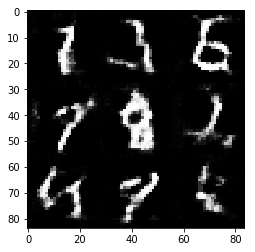

Epoch 1/2... Discriminator Loss: 1.6532... Generator Loss: 0.3741
Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 0.5297
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 0.5727
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 1.0368... Generator Loss: 0.6894
Epoch 1/2... Discriminator Loss: 1.6316... Generator Loss: 0.4040
Epoch 1/2... Discriminator Loss: 0.6365... Generator Loss: 1.1566
Epoch 1/2... Discriminator Loss: 1.2499... Generator Loss: 0.5210
Epoch 1/2... Discriminator Loss: 0.8882... Generator Loss: 0.9182
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 1.1412


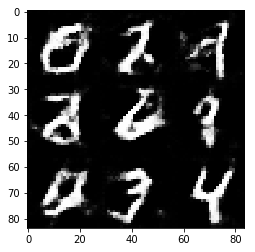

Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 0.7746... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 0.8722... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 0.4326... Generator Loss: 1.3148
Epoch 1/2... Discriminator Loss: 1.1874... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 0.4635
Epoch 1/2... Discriminator Loss: 0.8804... Generator Loss: 0.8782
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 0.6554
Epoch 1/2... Discriminator Loss: 0.6452... Generator Loss: 1.1264


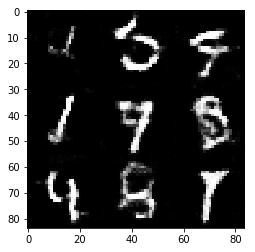

Epoch 1/2... Discriminator Loss: 1.7268... Generator Loss: 0.3645
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.4920
Epoch 1/2... Discriminator Loss: 0.6552... Generator Loss: 1.0328
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 0.7045
Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 0.5629
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 0.7995
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 0.6378
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.4845
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 0.4390
Epoch 1/2... Discriminator Loss: 0.6460... Generator Loss: 0.8592


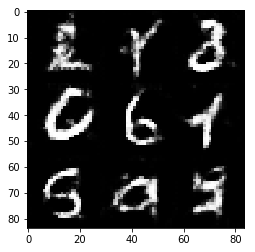

Epoch 1/2... Discriminator Loss: 2.3703... Generator Loss: 0.3382
Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 0.4563
Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 1.1005
Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 0.5335
Epoch 1/2... Discriminator Loss: 0.9175... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.5243
Epoch 1/2... Discriminator Loss: 1.5678... Generator Loss: 0.4186
Epoch 1/2... Discriminator Loss: 0.7551... Generator Loss: 0.8613
Epoch 1/2... Discriminator Loss: 0.7373... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 0.7989... Generator Loss: 0.9618


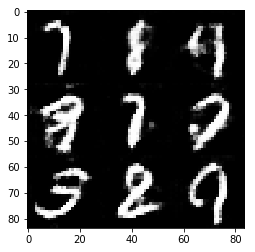

Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.4179
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 0.4923
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 2.1135
Epoch 1/2... Discriminator Loss: 1.5206... Generator Loss: 0.4459
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 1.8287
Epoch 1/2... Discriminator Loss: 1.8612... Generator Loss: 0.3594
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.5758
Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 0.5533
Epoch 1/2... Discriminator Loss: 1.7212... Generator Loss: 0.3897


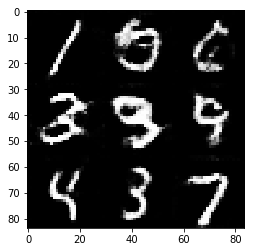

Epoch 1/2... Discriminator Loss: 0.5684... Generator Loss: 1.0333
Epoch 1/2... Discriminator Loss: 0.8620... Generator Loss: 0.7472
Epoch 1/2... Discriminator Loss: 0.8307... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 0.7423... Generator Loss: 1.4353
Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.5449
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 0.5220
Epoch 1/2... Discriminator Loss: 0.6707... Generator Loss: 1.5143
Epoch 1/2... Discriminator Loss: 2.1763... Generator Loss: 0.3822
Epoch 1/2... Discriminator Loss: 1.5189... Generator Loss: 0.3977


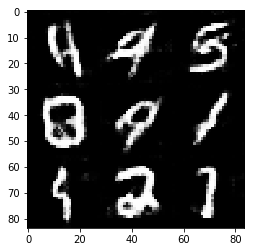

Epoch 1/2... Discriminator Loss: 0.8024... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 2.1411... Generator Loss: 0.3416
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 0.4999
Epoch 1/2... Discriminator Loss: 0.6674... Generator Loss: 2.0896
Epoch 1/2... Discriminator Loss: 0.8520... Generator Loss: 1.0675
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 1.7904
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 0.7958
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.5223
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 0.9925


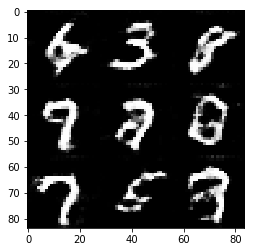

Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 0.7458
Epoch 1/2... Discriminator Loss: 0.8045... Generator Loss: 0.7721
Epoch 1/2... Discriminator Loss: 1.0982... Generator Loss: 0.6754
Epoch 1/2... Discriminator Loss: 0.9122... Generator Loss: 0.8753
Epoch 1/2... Discriminator Loss: 0.3804... Generator Loss: 1.5134
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 0.9860
Epoch 1/2... Discriminator Loss: 1.6135... Generator Loss: 0.3958
Epoch 1/2... Discriminator Loss: 1.7924... Generator Loss: 0.3979
Epoch 1/2... Discriminator Loss: 0.7815... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 1.1346... Generator Loss: 0.5363


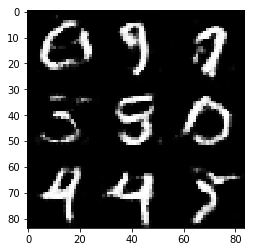

Epoch 1/2... Discriminator Loss: 0.9328... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 0.9767
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 2.1297... Generator Loss: 0.3641
Epoch 1/2... Discriminator Loss: 0.7713... Generator Loss: 0.7527
Epoch 1/2... Discriminator Loss: 0.5503... Generator Loss: 1.1554
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 0.5051
Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.4790
Epoch 2/2... Discriminator Loss: 1.6023... Generator Loss: 0.3932
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.6669


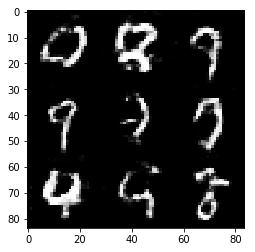

Epoch 2/2... Discriminator Loss: 0.8813... Generator Loss: 2.5040
Epoch 2/2... Discriminator Loss: 1.4345... Generator Loss: 0.4186
Epoch 2/2... Discriminator Loss: 0.7535... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 0.6531
Epoch 2/2... Discriminator Loss: 1.7907... Generator Loss: 0.3644
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 0.4959
Epoch 2/2... Discriminator Loss: 2.4507... Generator Loss: 0.3714
Epoch 2/2... Discriminator Loss: 0.5365... Generator Loss: 1.3780
Epoch 2/2... Discriminator Loss: 1.6886... Generator Loss: 0.4369
Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 0.7607


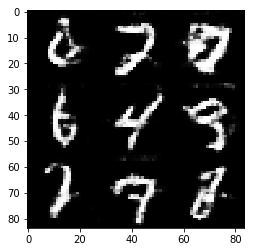

Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 0.6679
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 1.0618
Epoch 2/2... Discriminator Loss: 1.5088... Generator Loss: 0.4562
Epoch 2/2... Discriminator Loss: 1.1336... Generator Loss: 0.6116
Epoch 2/2... Discriminator Loss: 1.7798... Generator Loss: 0.4382
Epoch 2/2... Discriminator Loss: 1.3874... Generator Loss: 0.5636
Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.6397
Epoch 2/2... Discriminator Loss: 0.6806... Generator Loss: 1.0287
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.4395
Epoch 2/2... Discriminator Loss: 1.0949... Generator Loss: 0.5315


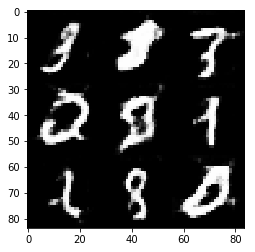

Epoch 2/2... Discriminator Loss: 1.7722... Generator Loss: 0.4124
Epoch 2/2... Discriminator Loss: 1.5080... Generator Loss: 0.4915
Epoch 2/2... Discriminator Loss: 0.6615... Generator Loss: 1.9456
Epoch 2/2... Discriminator Loss: 1.9425... Generator Loss: 0.3639
Epoch 2/2... Discriminator Loss: 1.7009... Generator Loss: 0.4323
Epoch 2/2... Discriminator Loss: 0.4644... Generator Loss: 1.7620
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 0.5474
Epoch 2/2... Discriminator Loss: 1.1711... Generator Loss: 0.8109
Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 0.5197
Epoch 2/2... Discriminator Loss: 1.5092... Generator Loss: 0.4644


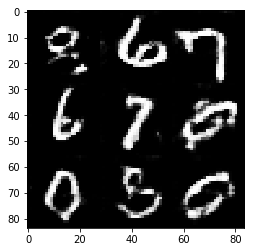

Epoch 2/2... Discriminator Loss: 0.8416... Generator Loss: 0.9189
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.5940
Epoch 2/2... Discriminator Loss: 1.1352... Generator Loss: 0.5297
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 1.5485... Generator Loss: 0.3977
Epoch 2/2... Discriminator Loss: 1.8347... Generator Loss: 0.3798
Epoch 2/2... Discriminator Loss: 1.6770... Generator Loss: 0.3866
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 0.7932... Generator Loss: 0.7115


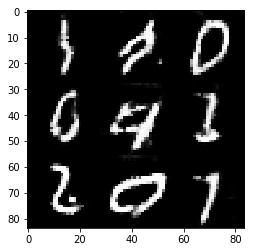

Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 0.7571
Epoch 2/2... Discriminator Loss: 1.9324... Generator Loss: 0.4012
Epoch 2/2... Discriminator Loss: 0.4561... Generator Loss: 2.0707
Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 1.0778... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 0.6760
Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.4309
Epoch 2/2... Discriminator Loss: 0.7602... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 2.0768... Generator Loss: 0.3643
Epoch 2/2... Discriminator Loss: 1.6973... Generator Loss: 0.4161


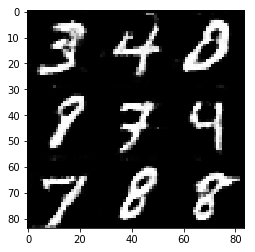

Epoch 2/2... Discriminator Loss: 0.4190... Generator Loss: 1.5916
Epoch 2/2... Discriminator Loss: 1.7924... Generator Loss: 0.4701
Epoch 2/2... Discriminator Loss: 0.6773... Generator Loss: 1.3426
Epoch 2/2... Discriminator Loss: 0.7181... Generator Loss: 1.4184
Epoch 2/2... Discriminator Loss: 1.7671... Generator Loss: 0.4887
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.4894
Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.2829... Generator Loss: 0.5411
Epoch 2/2... Discriminator Loss: 1.6502... Generator Loss: 3.3998
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 0.6751


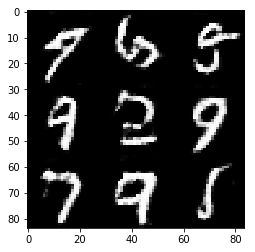

Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.5304
Epoch 2/2... Discriminator Loss: 2.1205... Generator Loss: 0.3635
Epoch 2/2... Discriminator Loss: 1.6818... Generator Loss: 0.3957
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 0.5676
Epoch 2/2... Discriminator Loss: 2.4436... Generator Loss: 0.3363
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 0.6380
Epoch 2/2... Discriminator Loss: 1.5999... Generator Loss: 0.5358
Epoch 2/2... Discriminator Loss: 1.5533... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 0.6348... Generator Loss: 1.0189


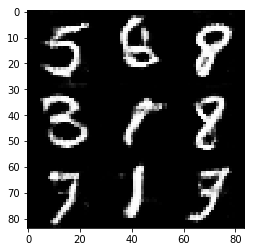

Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 0.5614
Epoch 2/2... Discriminator Loss: 1.2149... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 2.2798... Generator Loss: 0.3759
Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.5239
Epoch 2/2... Discriminator Loss: 1.6165... Generator Loss: 0.5560
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 1.6535
Epoch 2/2... Discriminator Loss: 1.8466... Generator Loss: 0.3606
Epoch 2/2... Discriminator Loss: 0.7069... Generator Loss: 0.8317


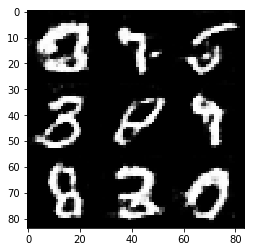

Epoch 2/2... Discriminator Loss: 0.6464... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.4751
Epoch 2/2... Discriminator Loss: 1.0700... Generator Loss: 0.6313
Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 0.8319
Epoch 2/2... Discriminator Loss: 0.5252... Generator Loss: 1.2667
Epoch 2/2... Discriminator Loss: 0.4951... Generator Loss: 1.2119
Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 2.6284
Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 0.6249
Epoch 2/2... Discriminator Loss: 0.4701... Generator Loss: 1.0944
Epoch 2/2... Discriminator Loss: 0.9408... Generator Loss: 0.6661


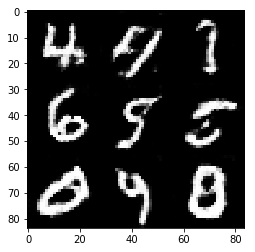

Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 1.1060
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 0.6826
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 1.1035
Epoch 2/2... Discriminator Loss: 1.7933... Generator Loss: 0.3721
Epoch 2/2... Discriminator Loss: 2.5493... Generator Loss: 0.3426
Epoch 2/2... Discriminator Loss: 0.7566... Generator Loss: 2.1446
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 1.3511
Epoch 2/2... Discriminator Loss: 0.5969... Generator Loss: 0.9652
Epoch 2/2... Discriminator Loss: 1.4478... Generator Loss: 0.4478
Epoch 2/2... Discriminator Loss: 1.2332... Generator Loss: 0.4830


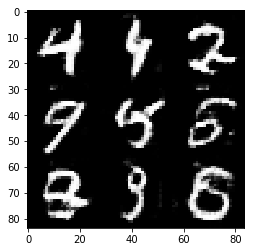

Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 0.6639
Epoch 2/2... Discriminator Loss: 0.8330... Generator Loss: 0.7448
Epoch 2/2... Discriminator Loss: 1.9619... Generator Loss: 0.4388
Epoch 2/2... Discriminator Loss: 2.7440... Generator Loss: 0.3592
Epoch 2/2... Discriminator Loss: 1.4998... Generator Loss: 0.4756
Epoch 2/2... Discriminator Loss: 0.5565... Generator Loss: 3.1007
Epoch 2/2... Discriminator Loss: 1.7948... Generator Loss: 0.5029
Epoch 2/2... Discriminator Loss: 0.4070... Generator Loss: 1.6980
Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 0.5658
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 1.6370


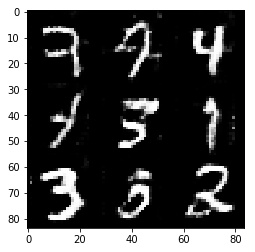

Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.4959
Epoch 2/2... Discriminator Loss: 1.7210... Generator Loss: 0.3888
Epoch 2/2... Discriminator Loss: 1.2866... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 0.7463... Generator Loss: 1.1766
Epoch 2/2... Discriminator Loss: 2.3792... Generator Loss: 0.3424
Epoch 2/2... Discriminator Loss: 1.2011... Generator Loss: 0.5423
Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 1.1785... Generator Loss: 0.6414
Epoch 2/2... Discriminator Loss: 1.6650... Generator Loss: 0.4426
Epoch 2/2... Discriminator Loss: 0.8418... Generator Loss: 0.7345


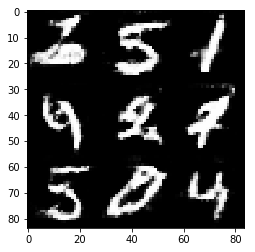

Epoch 2/2... Discriminator Loss: 2.3036... Generator Loss: 0.3404
Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 0.5926
Epoch 2/2... Discriminator Loss: 0.4417... Generator Loss: 1.1954
Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 0.7310
Epoch 2/2... Discriminator Loss: 1.9315... Generator Loss: 0.4208
Epoch 2/2... Discriminator Loss: 2.2200... Generator Loss: 0.3438
Epoch 2/2... Discriminator Loss: 1.9310... Generator Loss: 0.3815
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 1.7183
Epoch 2/2... Discriminator Loss: 0.8642... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.7844... Generator Loss: 0.3523


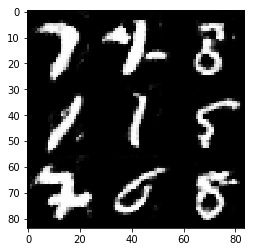

Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 0.6082
Epoch 2/2... Discriminator Loss: 2.1825... Generator Loss: 0.3846
Epoch 2/2... Discriminator Loss: 0.4653... Generator Loss: 1.3695
Epoch 2/2... Discriminator Loss: 0.9706... Generator Loss: 0.7287
Epoch 2/2... Discriminator Loss: 1.6142... Generator Loss: 0.3965
Epoch 2/2... Discriminator Loss: 1.3362... Generator Loss: 0.4585
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 0.6400
Epoch 2/2... Discriminator Loss: 0.8132... Generator Loss: 0.7114
Epoch 2/2... Discriminator Loss: 1.7258... Generator Loss: 0.3972


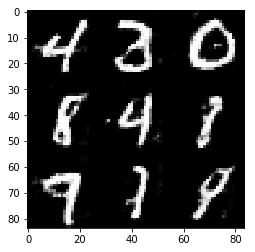

Epoch 2/2... Discriminator Loss: 1.0538... Generator Loss: 0.6636
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 0.6281
Epoch 2/2... Discriminator Loss: 0.6125... Generator Loss: 0.9190
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.6296
Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 1.2507
Epoch 2/2... Discriminator Loss: 1.4814... Generator Loss: 0.4522
Epoch 2/2... Discriminator Loss: 0.5872... Generator Loss: 1.4517
Epoch 2/2... Discriminator Loss: 1.9161... Generator Loss: 0.3969
Epoch 2/2... Discriminator Loss: 2.4670... Generator Loss: 0.3741


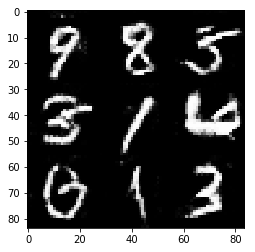

Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 0.8906... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.3756
Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 1.8628
Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.5087
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 0.2002... Generator Loss: 2.3101
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 0.5717
Epoch 2/2... Discriminator Loss: 0.3373... Generator Loss: 1.5370
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 0.6720


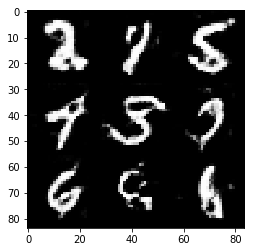

Epoch 2/2... Discriminator Loss: 0.8477... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 1.9093... Generator Loss: 0.3561
Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 1.1820
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 0.5983
Epoch 2/2... Discriminator Loss: 1.2068... Generator Loss: 0.5081
Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 0.4652
Epoch 2/2... Discriminator Loss: 0.6604... Generator Loss: 0.9666
Epoch 2/2... Discriminator Loss: 0.6906... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 0.3333... Generator Loss: 1.7700
Epoch 2/2... Discriminator Loss: 2.4864... Generator Loss: 0.3663


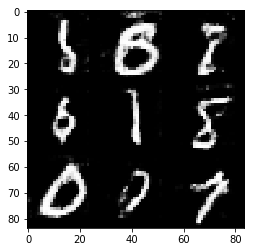

Epoch 2/2... Discriminator Loss: 0.3314... Generator Loss: 1.5273
Epoch 2/2... Discriminator Loss: 1.1905... Generator Loss: 1.4441
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.5182
Epoch 2/2... Discriminator Loss: 1.5628... Generator Loss: 0.4819
Epoch 2/2... Discriminator Loss: 1.8482... Generator Loss: 0.4674
Epoch 2/2... Discriminator Loss: 0.6154... Generator Loss: 1.2450
Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 0.8399
Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 1.1832
Epoch 2/2... Discriminator Loss: 0.8799... Generator Loss: 0.9674
Epoch 2/2... Discriminator Loss: 1.4668... Generator Loss: 0.4706


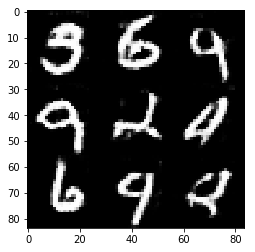

Epoch 2/2... Discriminator Loss: 0.3825... Generator Loss: 2.2640
Epoch 2/2... Discriminator Loss: 0.1283... Generator Loss: 2.9043
Epoch 2/2... Discriminator Loss: 0.7023... Generator Loss: 0.9988
Epoch 2/2... Discriminator Loss: 1.6352... Generator Loss: 0.4201
Epoch 2/2... Discriminator Loss: 0.6750... Generator Loss: 1.2482


In [171]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 6.5355
Epoch 1/1... Discriminator Loss: 0.2226... Generator Loss: 5.5202
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 2.2107
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 2.4241
Epoch 1/1... Discriminator Loss: 1.8716... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 2.3364... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 0.4553... Generator Loss: 6.6799
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 3.8794
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 3.1677


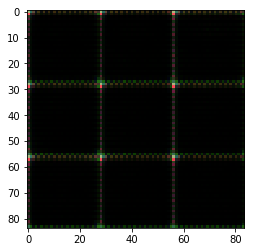

Epoch 1/1... Discriminator Loss: 1.9192... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 2.1897
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 0.3242... Generator Loss: 1.8575
Epoch 1/1... Discriminator Loss: 0.2967... Generator Loss: 1.5505
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 1.2570
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 2.7903


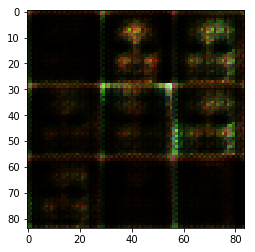

Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.4358
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 1.5897... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 1.6071... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.5099
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.5267


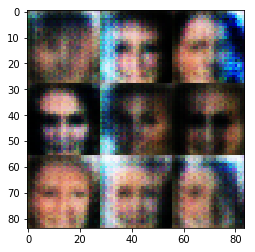

Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.8598... Generator Loss: 2.5246
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 0.3185... Generator Loss: 1.6243
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.6969


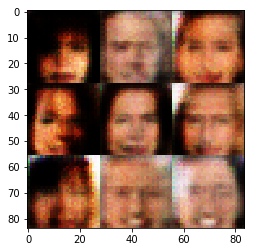

Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 0.5006... Generator Loss: 2.6040
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 0.0852... Generator Loss: 2.8798
Epoch 1/1... Discriminator Loss: 0.3119... Generator Loss: 1.5119
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 2.4954... Generator Loss: 0.3595
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 2.0977... Generator Loss: 0.3736
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 1.1883


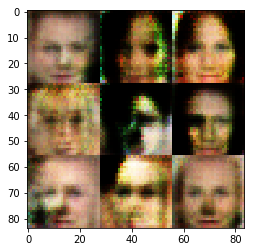

Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 2.6205... Generator Loss: 3.9878
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 1.3138
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 2.0897
Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 0.8331


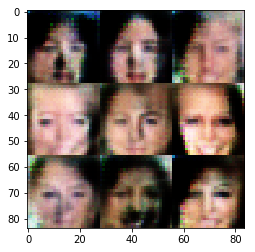

Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 1.2833
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 1.3672
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 3.2645
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.5730


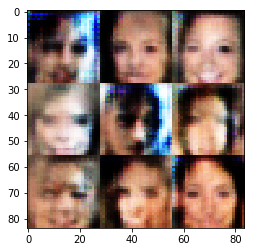

Epoch 1/1... Discriminator Loss: 0.4881... Generator Loss: 1.2180
Epoch 1/1... Discriminator Loss: 0.5998... Generator Loss: 1.3848
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.8616
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.1813
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 0.8418


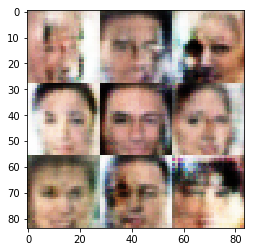

Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 2.3285
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 1.9727... Generator Loss: 2.9026
Epoch 1/1... Discriminator Loss: 0.1955... Generator Loss: 2.6734
Epoch 1/1... Discriminator Loss: 0.7903... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 2.2261
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.5888


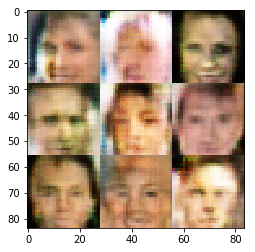

Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 1.4661
Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 1.0827
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 1.8752
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 2.7783
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.7523
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.4826


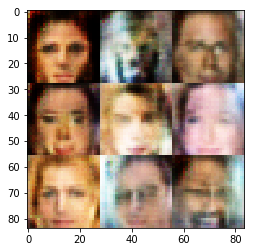

Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.4810
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.4292
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 3.4233
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 2.0986
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.9248


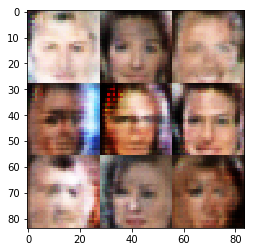

Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.4082
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 2.1918
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.7198
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.4688
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.0999


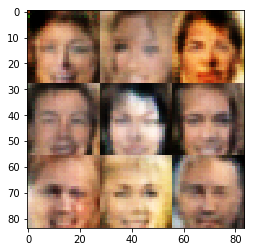

Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 2.6714... Generator Loss: 0.3371
Epoch 1/1... Discriminator Loss: 1.6561... Generator Loss: 0.4065
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.8437... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 2.3582


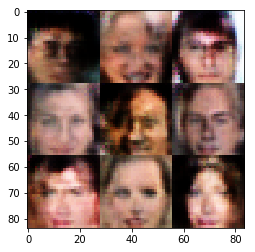

Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.9581... Generator Loss: 0.3546
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.5746


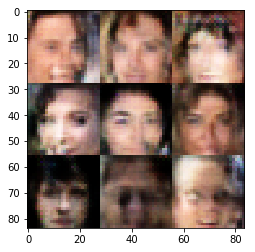

Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.9025... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 1.7040
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 0.7502


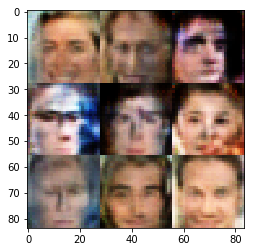

Epoch 1/1... Discriminator Loss: 0.6153... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 1.7553
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 2.7146
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.8401... Generator Loss: 3.1259
Epoch 1/1... Discriminator Loss: 1.8936... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 2.0493... Generator Loss: 0.3429


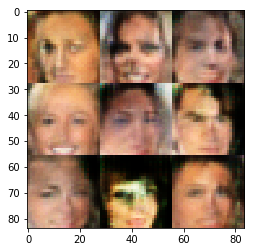

Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 2.2611
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 2.1169
Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 2.1249
Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.6253


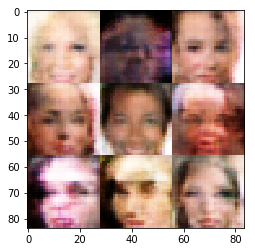

Epoch 1/1... Discriminator Loss: 2.0774... Generator Loss: 0.3497
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 1.5823
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.8838
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 1.2913
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 2.4897
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.1336
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.5931


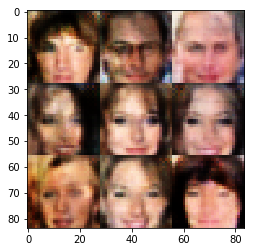

Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 0.5685... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.5619
Epoch 1/1... Discriminator Loss: 0.1852... Generator Loss: 4.4109
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.4641
Epoch 1/1... Discriminator Loss: 1.9531... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 1.3474


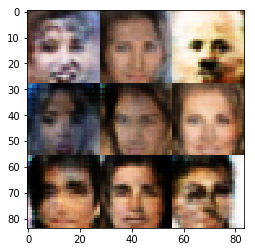

Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 2.4935
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.4354
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 1.8545... Generator Loss: 0.3626
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 1.2927
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.9422... Generator Loss: 0.3609
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.4224


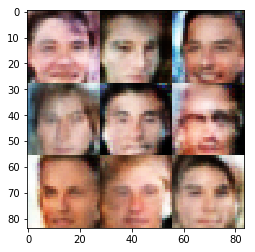

Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 1.5701
Epoch 1/1... Discriminator Loss: 1.8225... Generator Loss: 2.6644
Epoch 1/1... Discriminator Loss: 1.9126... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 1.6985
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.6762
Epoch 1/1... Discriminator Loss: 1.8689... Generator Loss: 0.3617
Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 1.6563
Epoch 1/1... Discriminator Loss: 2.1104... Generator Loss: 0.3436
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.4117
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.0584


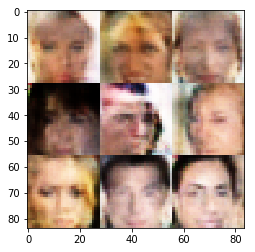

Epoch 1/1... Discriminator Loss: 0.3530... Generator Loss: 1.6295
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 2.2811
Epoch 1/1... Discriminator Loss: 2.2456... Generator Loss: 0.3341
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 2.6325
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.6055
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 0.6653... Generator Loss: 1.0249


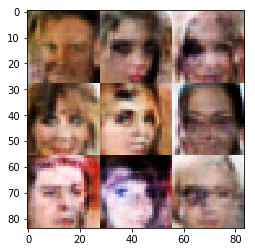

Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.3334
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 2.3361
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 1.3348
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 2.3507... Generator Loss: 0.3326
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.6881


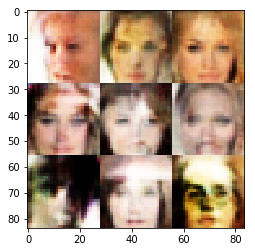

Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.8283... Generator Loss: 0.3842
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 2.2842... Generator Loss: 0.3395
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.9460... Generator Loss: 0.3550
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 1.4879
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.9311


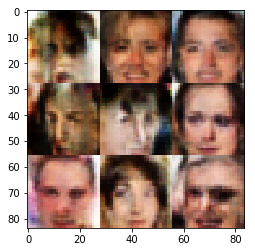

Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 3.7596... Generator Loss: 3.9968
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 2.1384... Generator Loss: 0.3573
Epoch 1/1... Discriminator Loss: 0.5773... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 0.7460


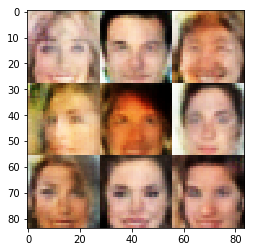

Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 1.9321
Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.4020
Epoch 1/1... Discriminator Loss: 1.9133... Generator Loss: 0.3619
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 2.3654... Generator Loss: 4.2879
Epoch 1/1... Discriminator Loss: 1.6601... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 2.2918


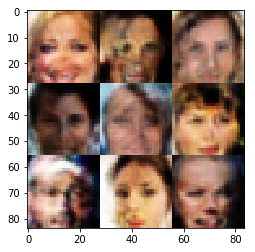

Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 1.8011
Epoch 1/1... Discriminator Loss: 2.3161... Generator Loss: 0.3366
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 0.6302... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 1.4844
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 2.0160... Generator Loss: 0.3470


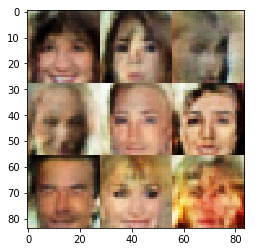

Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 2.3601... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.9529
Epoch 1/1... Discriminator Loss: 1.7672... Generator Loss: 2.6361
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.4303
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.5724


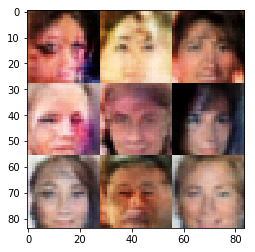

Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 1.4637
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.3797
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 2.1726
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.9324
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 0.7739


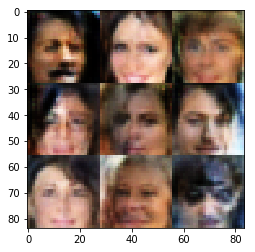

Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 2.1005
Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 0.7322... Generator Loss: 1.5883
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.4411
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 2.5317


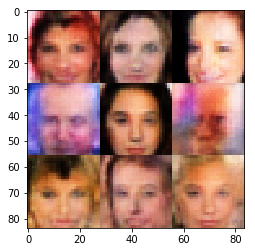

Epoch 1/1... Discriminator Loss: 3.1367... Generator Loss: 0.3605
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 1.6859
Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 2.1175
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 2.0250
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 2.3206
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.6345


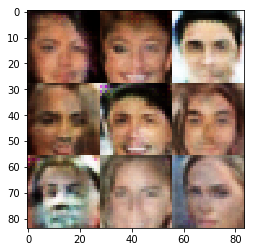

Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 3.5563
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.4016
Epoch 1/1... Discriminator Loss: 1.7968... Generator Loss: 0.3728
Epoch 1/1... Discriminator Loss: 1.9794... Generator Loss: 0.3663
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 0.7194


In [164]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.